In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import zipfile
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

Loading dataset...


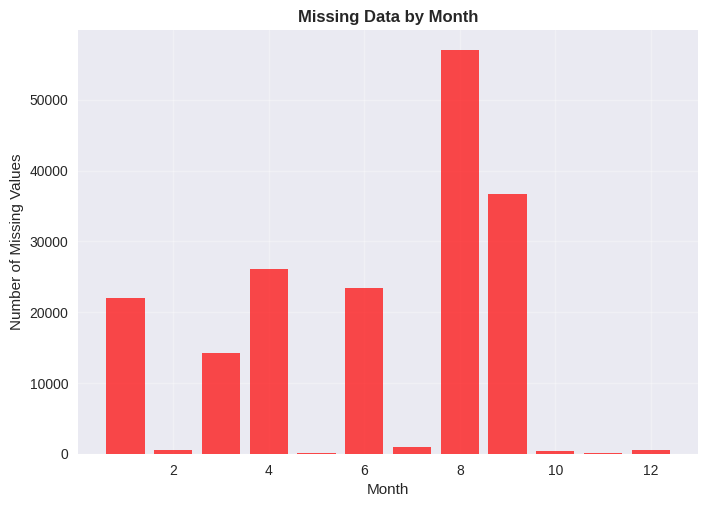

Dataset shape: (2075259, 8)
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Missing values: 181853


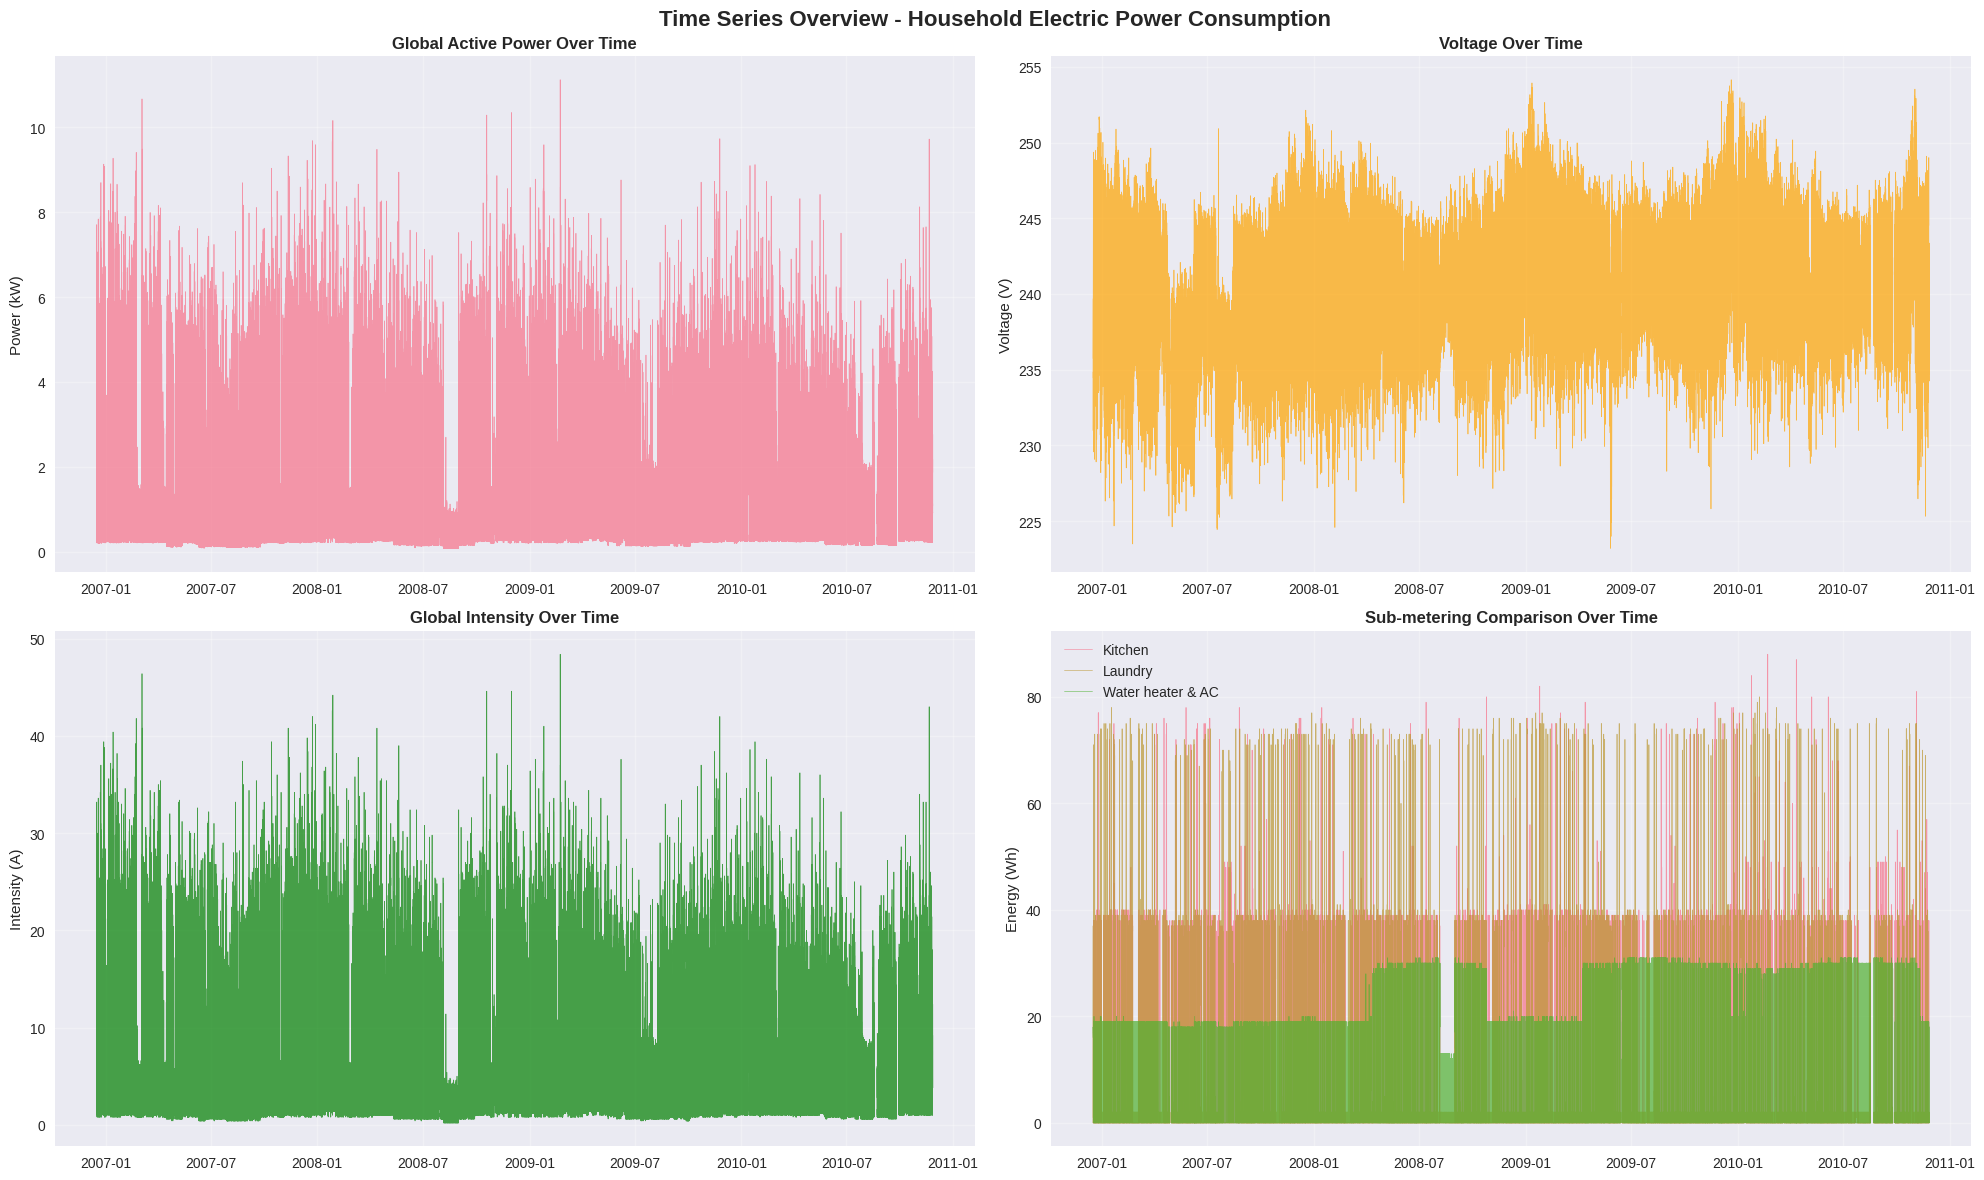

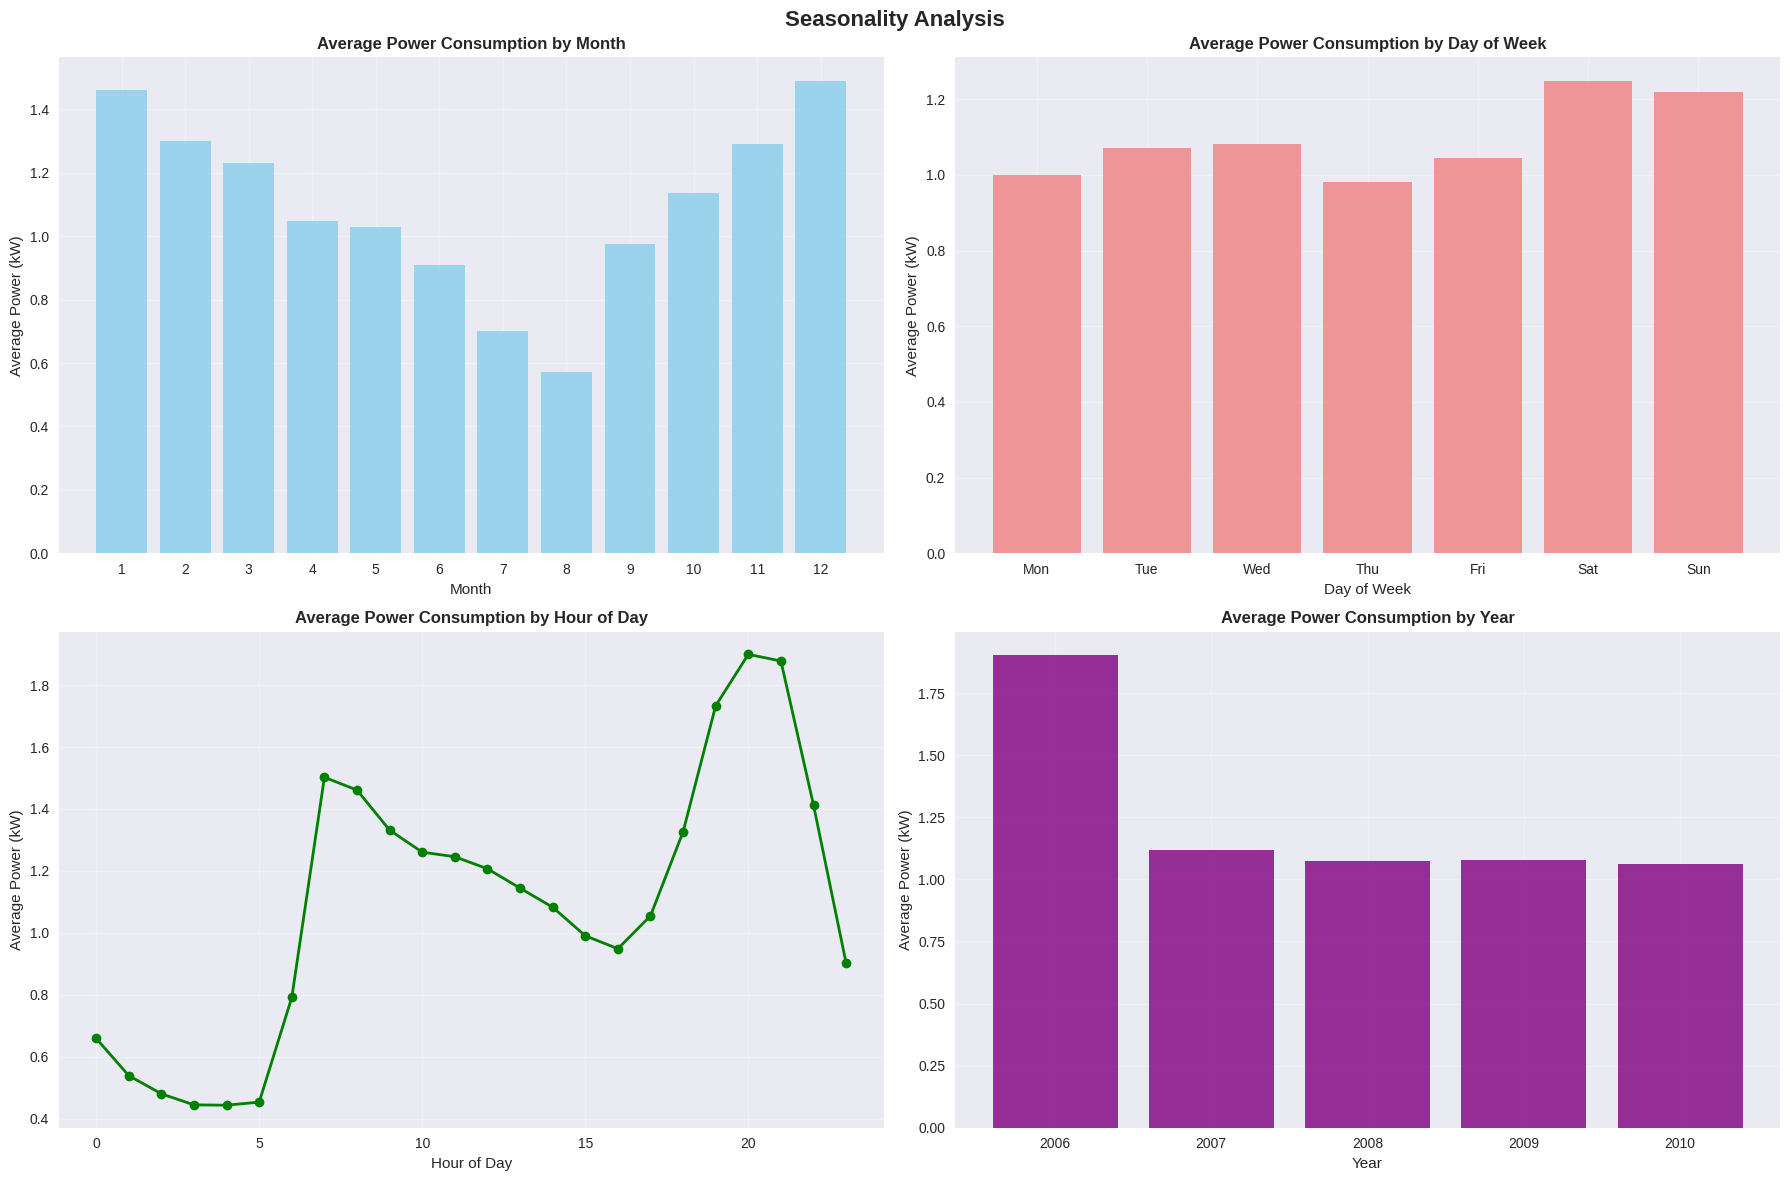

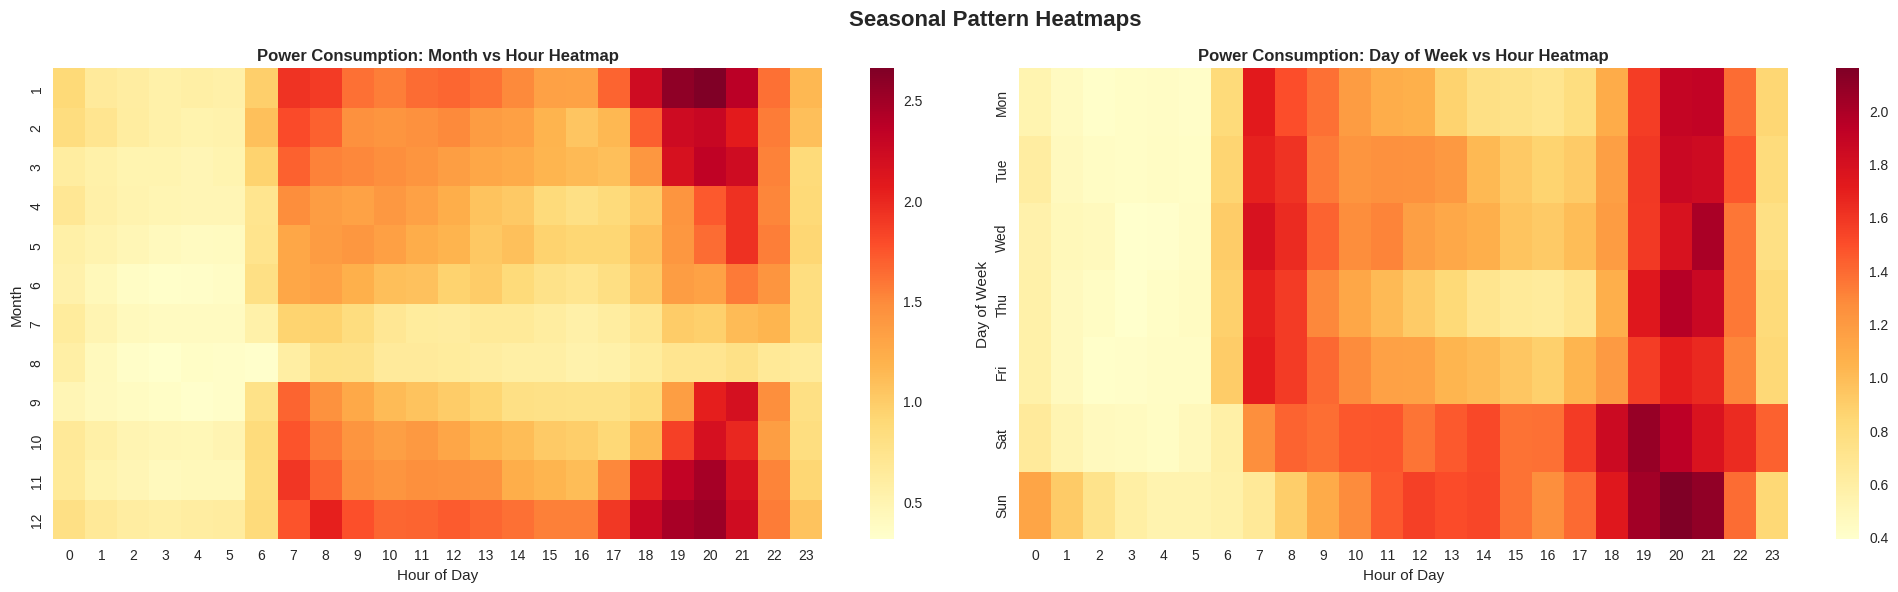

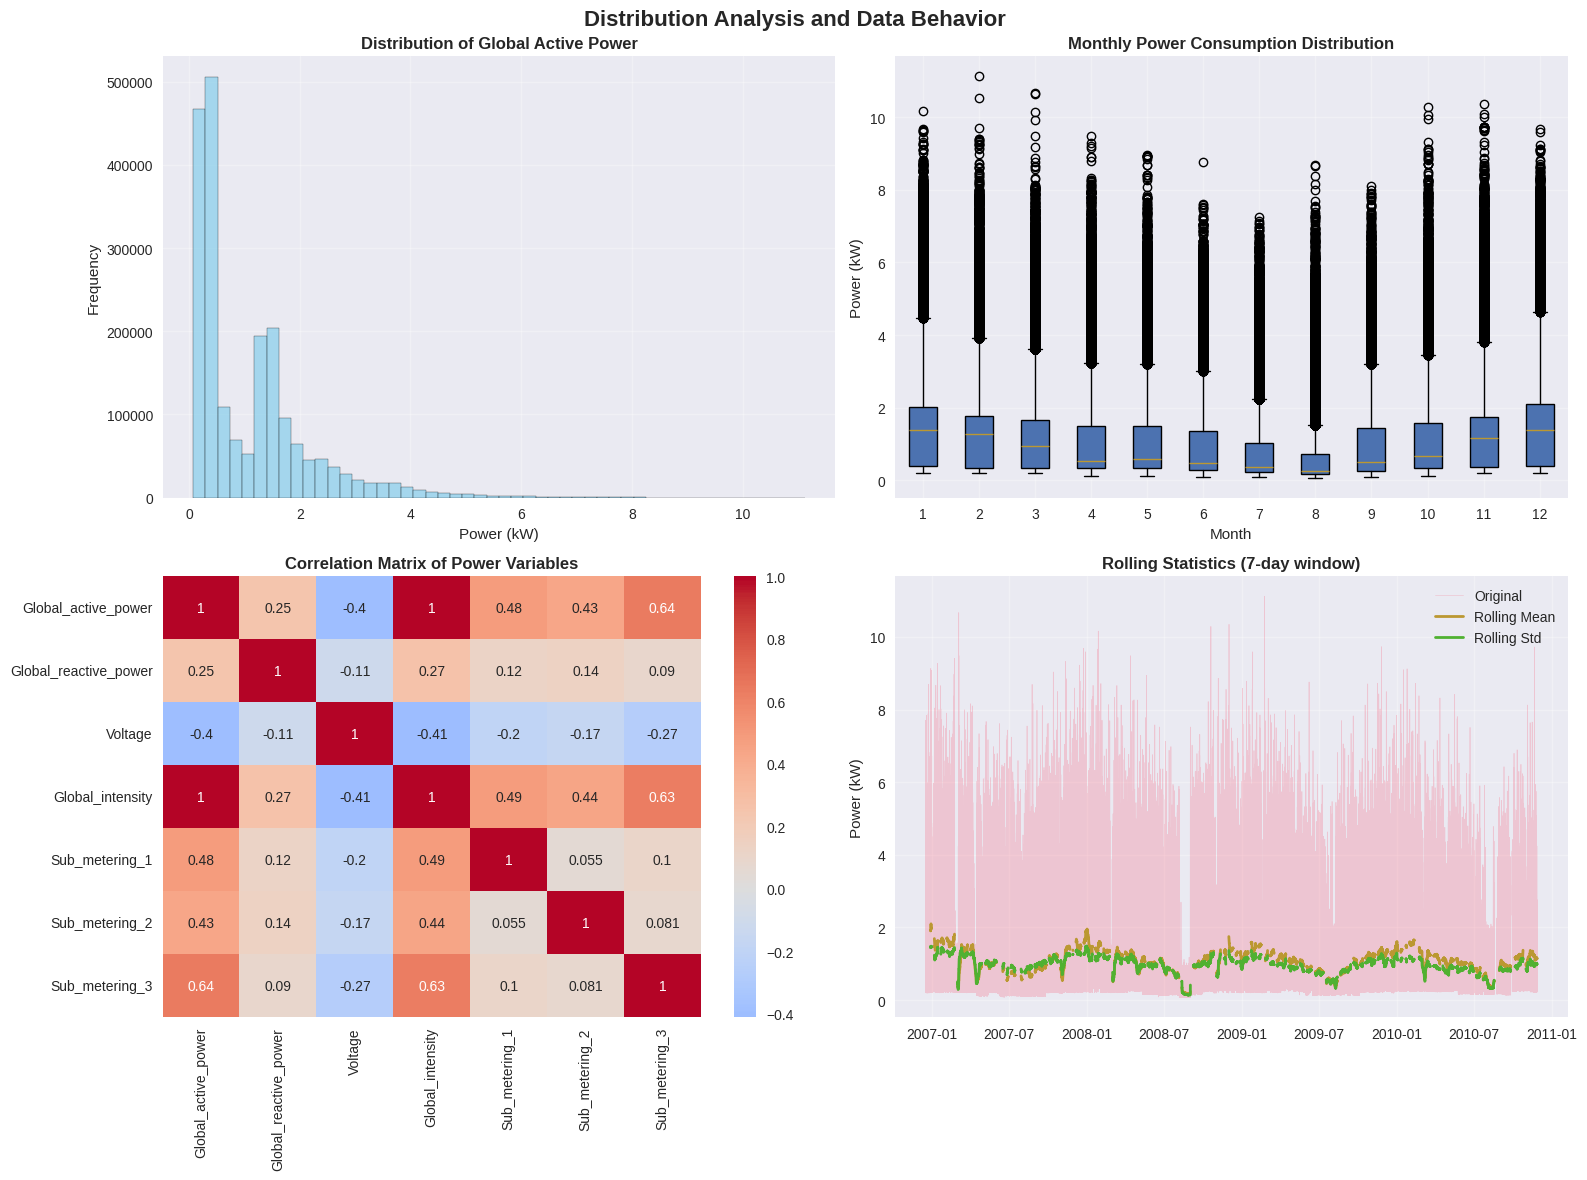

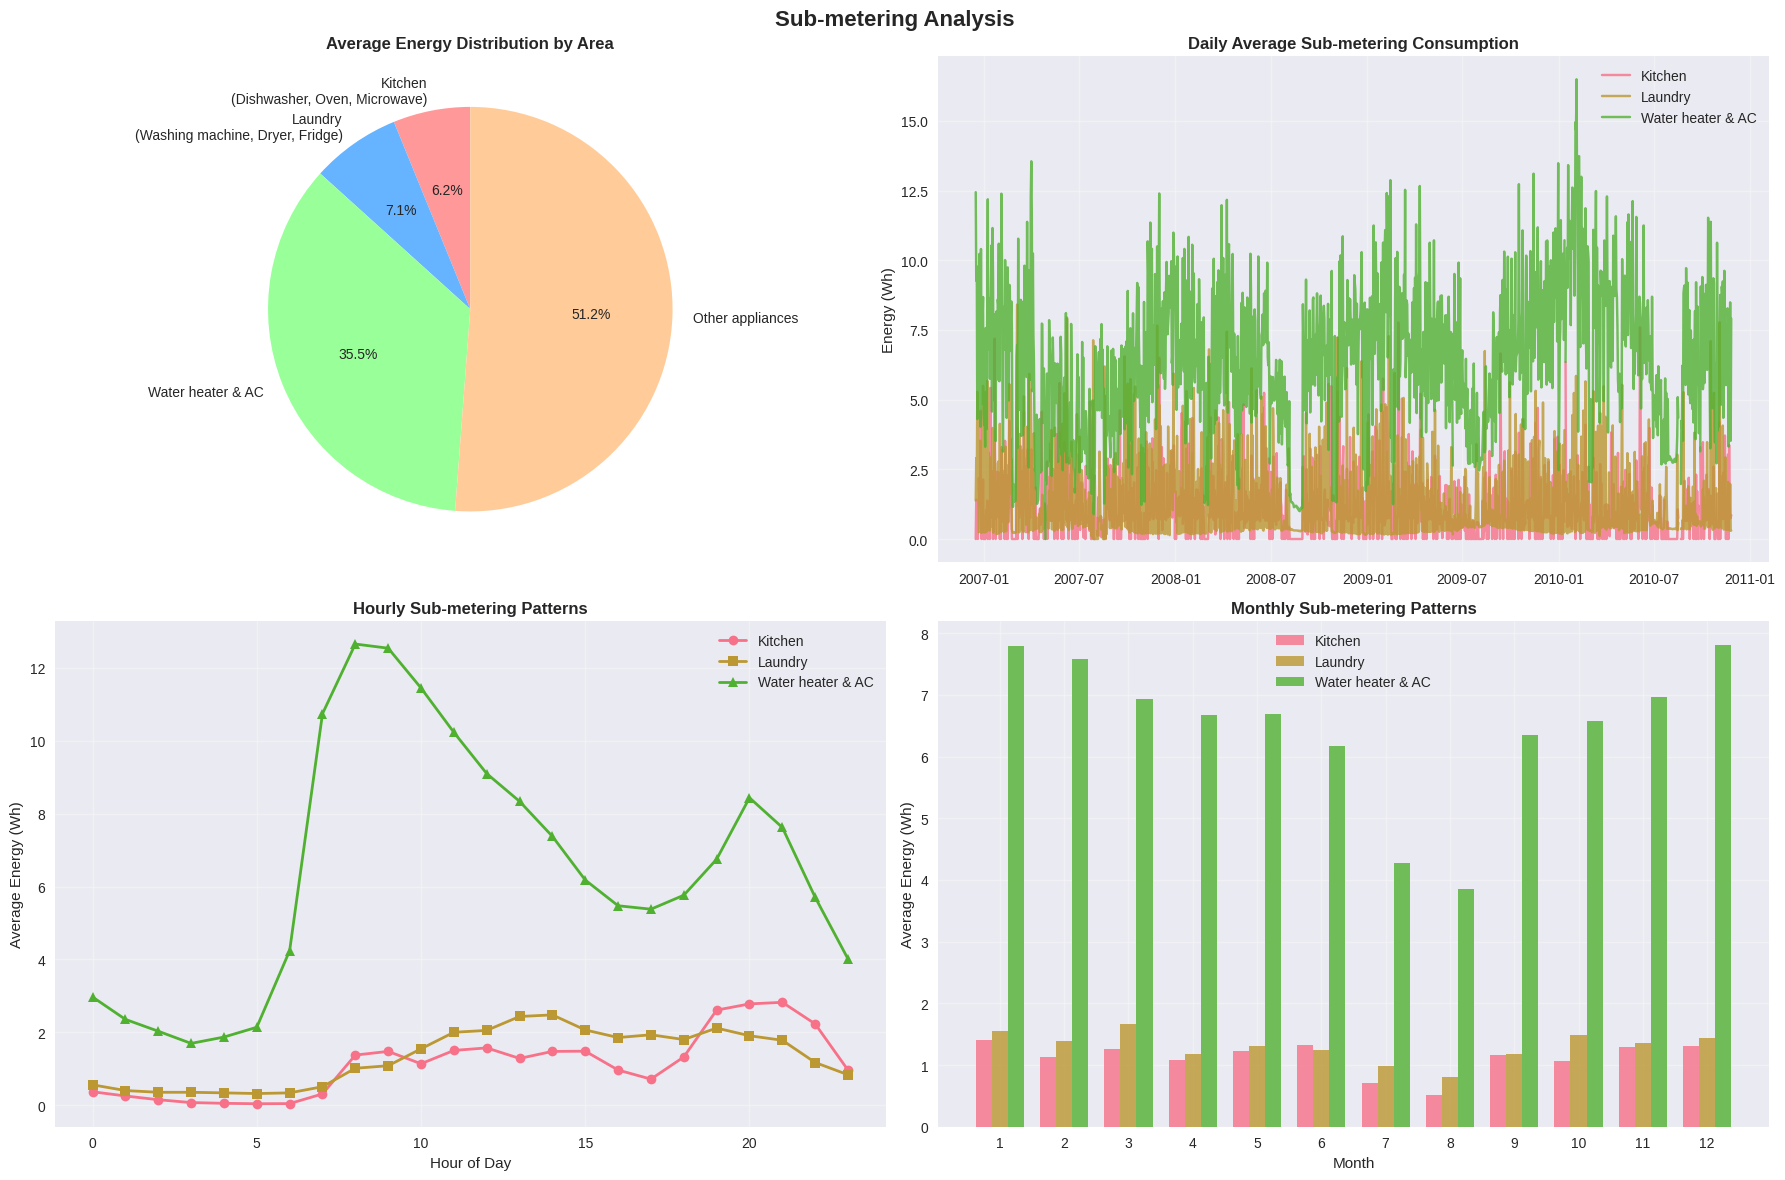

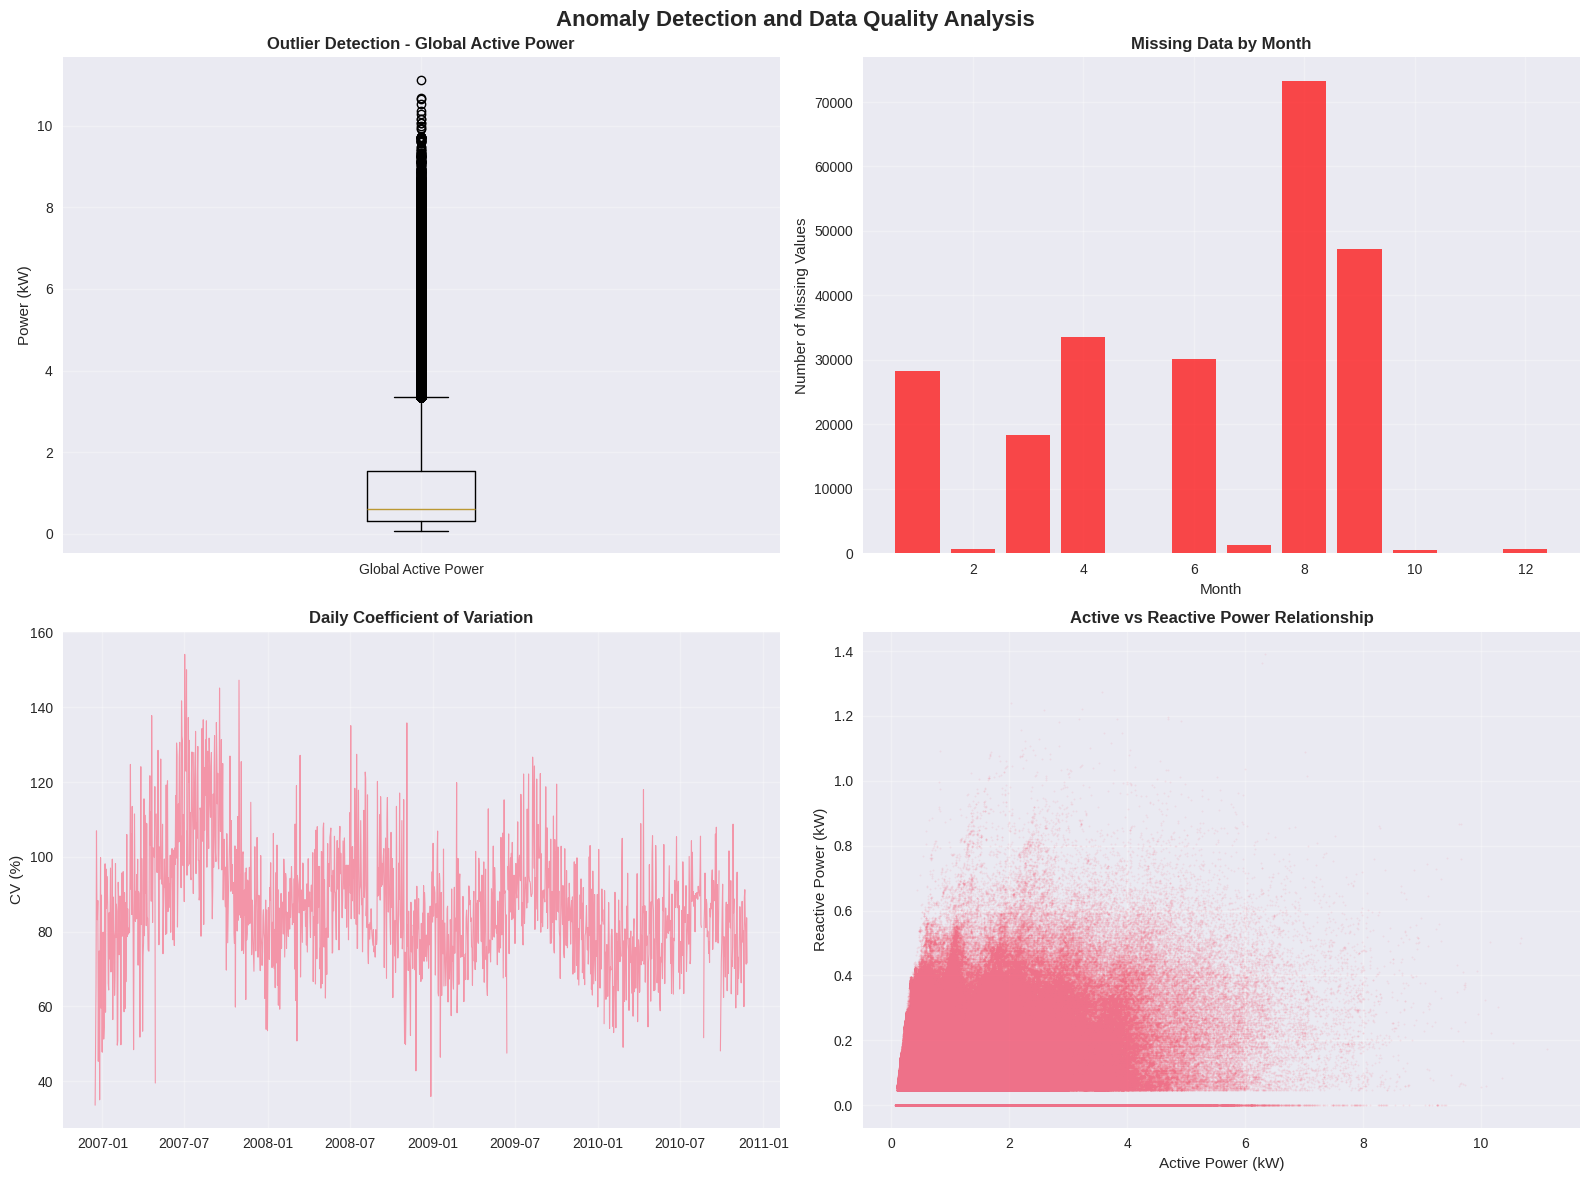

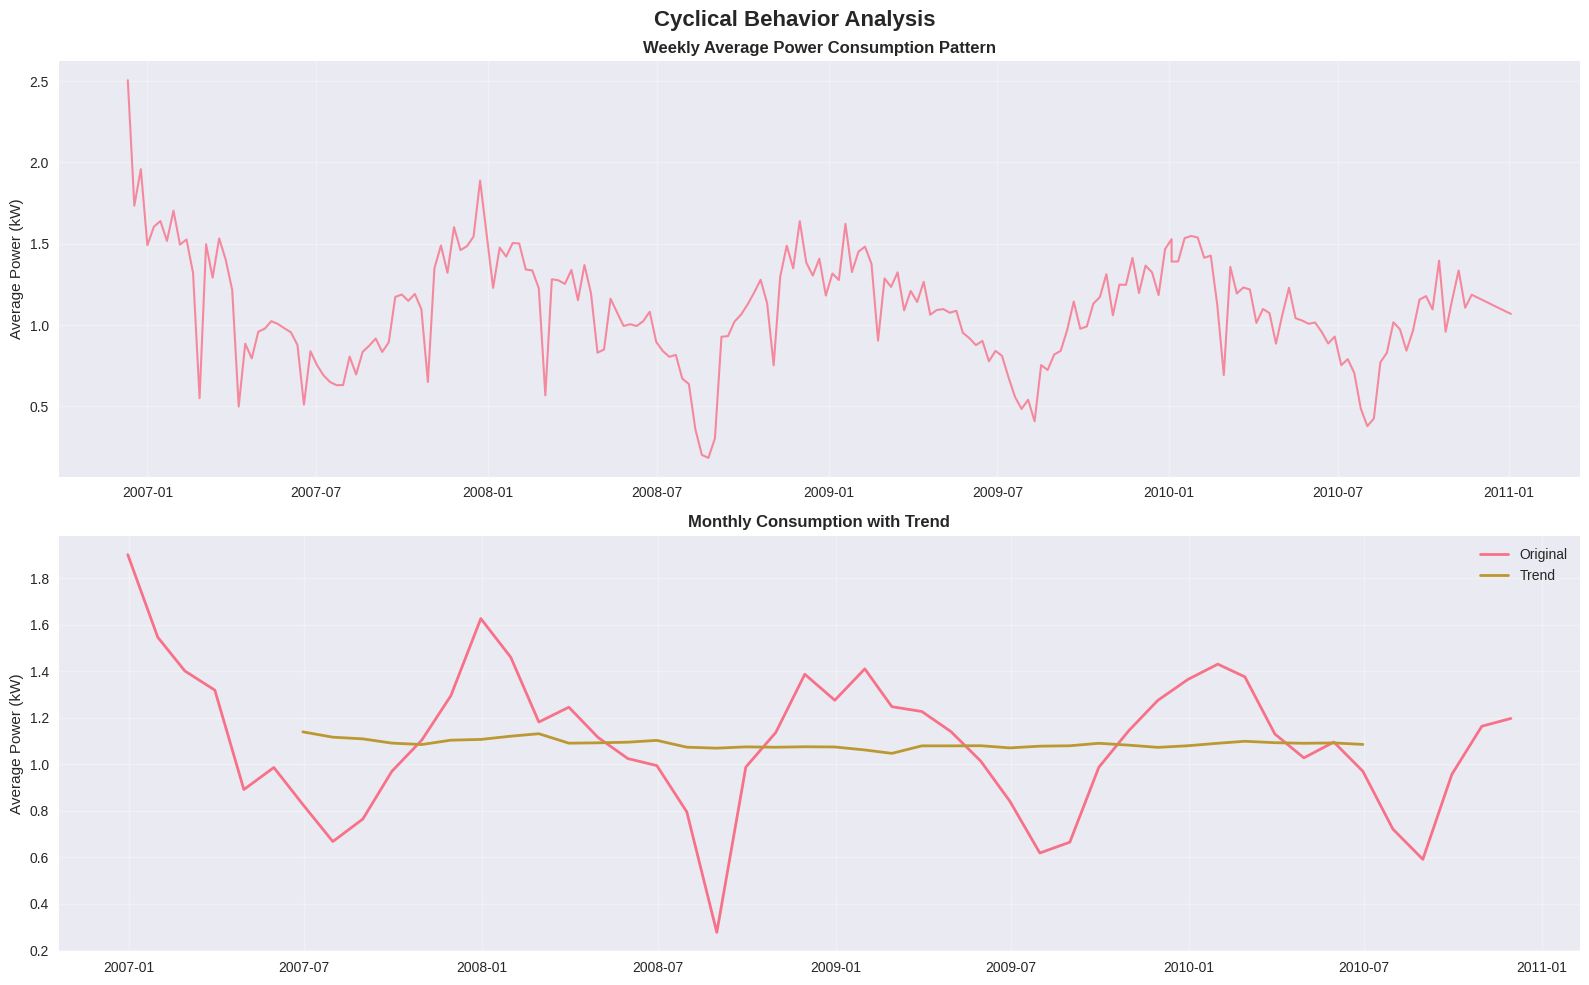


DATASET SUMMARY STATISTICS
Dataset period: 2006-12-16 to 2010-11-26
Total observations: 2,075,259
Missing data percentage: 0.75%

Power Consumption Statistics:
Average Global Active Power: 1.092 kW
Maximum Global Active Power: 11.122 kW
Minimum Global Active Power: 0.076 kW
Standard Deviation: 1.057 kW

Sub-metering Average Consumption:
Kitchen (Sub_metering_1): 1.12 Wh
Laundry (Sub_metering_2): 1.30 Wh
Water heater & AC (Sub_metering_3): 6.46 Wh

Key Insights:
- Peak consumption hours: 7-9 AM and 6-9 PM (typical household patterns)
- Higher consumption in winter months (heating needs)
- Weekend vs weekday differences in consumption patterns
- Strong correlation between active power and intensity
- Sub-metering shows kitchen and water heater/AC as major consumers


In [7]:
# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Download and extract the dataset
def download_and_load_data():
    """Download the dataset and load it into a pandas DataFrame"""
    url = 'https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip'

    # Download the zip file
    response = requests.get(url)
    zip_data = BytesIO(response.content)

    # Extract and read the data
    with zipfile.ZipFile(zip_data, 'r') as zip_ref:
        with zip_ref.open('household_power_consumption.txt') as file:
            # Read the data with proper parsing
            df = pd.read_csv(file, sep=';', low_memory=False)

    return df

# Load and preprocess the data
print("Loading dataset...")
df = download_and_load_data()

# Data preprocessing
def preprocess_data(df):
    """Clean and preprocess the dataset"""
    # Replace '?' with NaN
    df = df.replace('?', np.nan)

    # Convert Date and Time columns to datetime
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')

    # Convert numeric columns to float
    numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                   'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Set DateTime as index
    df = df.set_index('DateTime')

    # Drop original Date and Time columns
    df = df.drop(['Date', 'Time'], axis=1)

    #Number of Missing Values
    NumOfMV = df.isnull().sum().sum()

    # Missing data pattern
    df['Month'] = df.index.month
    missing_by_month = df.groupby('Month').apply(lambda x: x.isnull().sum().sum())
    plt.bar(missing_by_month.index, missing_by_month.values, color='red', alpha=0.7)
    plt.title('Missing Data by Month', fontweight='bold')
    plt.xlabel('Month')
    plt.ylabel('Number of Missing Values')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Remove rows with all NaN values
    df = df.dropna(how='all')

    return (df, NumOfMV)

df, NumOfMV = preprocess_data(df)
print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
#print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Missing values: {NumOfMV}")

# Create additional time features for analysis
df['Year'] = df.index.year
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek
df['Hour'] = df.index.hour
df['DayOfYear'] = df.index.dayofyear

# Calculate additional metrics
df['Total_sub_metering'] = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['Other_active_power'] = (df['Global_active_power'] * 1000/60) - df['Total_sub_metering']

# 1. TIME SERIES OVERVIEW AND TREND ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Time Series Overview - Household Electric Power Consumption', fontsize=16, fontweight='bold')

# Plot 1: Global Active Power over time
axes[0,0].plot(df.index, df['Global_active_power'], alpha=0.7, linewidth=0.5)
axes[0,0].set_title('Global Active Power Over Time', fontweight='bold')
axes[0,0].set_ylabel('Power (kW)')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Voltage over time
axes[0,1].plot(df.index, df['Voltage'], alpha=0.7, linewidth=0.5, color='orange')
axes[0,1].set_title('Voltage Over Time', fontweight='bold')
axes[0,1].set_ylabel('Voltage (V)')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Global Intensity over time
axes[1,0].plot(df.index, df['Global_intensity'], alpha=0.7, linewidth=0.5, color='green')
axes[1,0].set_title('Global Intensity Over Time', fontweight='bold')
axes[1,0].set_ylabel('Intensity (A)')
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Sub-metering comparison
axes[1,1].plot(df.index, df['Sub_metering_1'], alpha=0.7, linewidth=0.5, label='Kitchen')
axes[1,1].plot(df.index, df['Sub_metering_2'], alpha=0.7, linewidth=0.5, label='Laundry')
axes[1,1].plot(df.index, df['Sub_metering_3'], alpha=0.7, linewidth=0.5, label='Water heater & AC')
axes[1,1].set_title('Sub-metering Comparison Over Time', fontweight='bold')
axes[1,1].set_ylabel('Energy (Wh)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. SEASONALITY ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Seasonality Analysis', fontsize=16, fontweight='bold')

# Monthly patterns
monthly_avg = df.groupby('Month')['Global_active_power'].mean()
axes[0,0].bar(monthly_avg.index, monthly_avg.values, color='skyblue', alpha=0.8)
axes[0,0].set_title('Average Power Consumption by Month', fontweight='bold')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Average Power (kW)')
axes[0,0].set_xticks(range(1, 13))
axes[0,0].grid(True, alpha=0.3)

# Daily patterns (by day of week)
daily_avg = df.groupby('DayOfWeek')['Global_active_power'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(range(7), daily_avg.values, color='lightcoral', alpha=0.8)
axes[0,1].set_title('Average Power Consumption by Day of Week', fontweight='bold')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Average Power (kW)')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(day_names)
axes[0,1].grid(True, alpha=0.3)

# Hourly patterns
hourly_avg = df.groupby('Hour')['Global_active_power'].mean()
axes[1,0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, color='green')
axes[1,0].set_title('Average Power Consumption by Hour of Day', fontweight='bold')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Average Power (kW)')
axes[1,0].grid(True, alpha=0.3)

# Yearly patterns
yearly_avg = df.groupby('Year')['Global_active_power'].mean()
axes[1,1].bar(yearly_avg.index, yearly_avg.values, color='purple', alpha=0.8)
axes[1,1].set_title('Average Power Consumption by Year', fontweight='bold')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Average Power (kW)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 3. HEATMAP FOR SEASONAL PATTERNS
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle('Seasonal Pattern Heatmaps', fontsize=16, fontweight='bold')

# Month vs Hour heatmap
pivot_month_hour = df.groupby(['Month', 'Hour'])['Global_active_power'].mean().unstack()
sns.heatmap(pivot_month_hour, annot=False, cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Power Consumption: Month vs Hour Heatmap', fontweight='bold')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Month')

# Day of Week vs Hour heatmap
pivot_dow_hour = df.groupby(['DayOfWeek', 'Hour'])['Global_active_power'].mean().unstack()
sns.heatmap(pivot_dow_hour, annot=False, cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Power Consumption: Day of Week vs Hour Heatmap', fontweight='bold')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Day of Week')
axes[1].set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

plt.tight_layout()
plt.show()

# 4. DISTRIBUTION ANALYSIS AND STATIONARITY CHECK
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution Analysis and Data Behavior', fontsize=16, fontweight='bold')

# Distribution of Global Active Power
axes[0,0].hist(df['Global_active_power'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Global Active Power', fontweight='bold')
axes[0,0].set_xlabel('Power (kW)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# Box plot by month to show seasonal variation
monthly_data = [df[df['Month'] == month]['Global_active_power'].dropna() for month in range(1, 13)]
box_plot = axes[0,1].boxplot(monthly_data, patch_artist=True)
axes[0,1].set_title('Monthly Power Consumption Distribution', fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Power (kW)')
axes[0,1].grid(True, alpha=0.3)

# Correlation heatmap
numeric_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
               'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
axes[1,0].set_title('Correlation Matrix of Power Variables', fontweight='bold')

# Rolling mean and std to check stationarity
window = 24*60*7  # One week rolling window
rolling_mean = df['Global_active_power'].rolling(window=window).mean()
rolling_std = df['Global_active_power'].rolling(window=window).std()

axes[1,1].plot(df.index, df['Global_active_power'], alpha=0.3, label='Original', linewidth=0.5)
axes[1,1].plot(rolling_mean.index, rolling_mean, label='Rolling Mean', linewidth=2)
axes[1,1].plot(rolling_std.index, rolling_std, label='Rolling Std', linewidth=2)
axes[1,1].set_title('Rolling Statistics (7-day window)', fontweight='bold')
axes[1,1].set_ylabel('Power (kW)')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. SUB-METERING DETAILED ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Sub-metering Analysis', fontsize=16, fontweight='bold')

# Pie chart of average sub-metering consumption
sub_metering_avg = [
    df['Sub_metering_1'].mean(),
    df['Sub_metering_2'].mean(),
    df['Sub_metering_3'].mean(),
    df['Other_active_power'].mean()
]
labels = ['Kitchen\n(Dishwasher, Oven, Microwave)',
          'Laundry\n(Washing machine, Dryer, Fridge)',
          'Water heater & AC',
          'Other appliances']
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

axes[0,0].pie(sub_metering_avg, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Average Energy Distribution by Area', fontweight='bold')

# Sub-metering over time (resampled to daily for clarity)
daily_sub = df[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].resample('D').mean()
axes[0,1].plot(daily_sub.index, daily_sub['Sub_metering_1'], label='Kitchen', alpha=0.8)
axes[0,1].plot(daily_sub.index, daily_sub['Sub_metering_2'], label='Laundry', alpha=0.8)
axes[0,1].plot(daily_sub.index, daily_sub['Sub_metering_3'], label='Water heater & AC', alpha=0.8)
axes[0,1].set_title('Daily Average Sub-metering Consumption', fontweight='bold')
axes[0,1].set_ylabel('Energy (Wh)')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Hourly patterns for each sub-metering
hourly_sub1 = df.groupby('Hour')['Sub_metering_1'].mean()
hourly_sub2 = df.groupby('Hour')['Sub_metering_2'].mean()
hourly_sub3 = df.groupby('Hour')['Sub_metering_3'].mean()

axes[1,0].plot(hourly_sub1.index, hourly_sub1.values, marker='o', label='Kitchen', linewidth=2)
axes[1,0].plot(hourly_sub2.index, hourly_sub2.values, marker='s', label='Laundry', linewidth=2)
axes[1,0].plot(hourly_sub3.index, hourly_sub3.values, marker='^', label='Water heater & AC', linewidth=2)
axes[1,0].set_title('Hourly Sub-metering Patterns', fontweight='bold')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Average Energy (Wh)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Monthly sub-metering patterns
monthly_sub1 = df.groupby('Month')['Sub_metering_1'].mean()
monthly_sub2 = df.groupby('Month')['Sub_metering_2'].mean()
monthly_sub3 = df.groupby('Month')['Sub_metering_3'].mean()

x = np.arange(1, 13)
width = 0.25

axes[1,1].bar(x - width, monthly_sub1.values, width, label='Kitchen', alpha=0.8)
axes[1,1].bar(x, monthly_sub2.values, width, label='Laundry', alpha=0.8)
axes[1,1].bar(x + width, monthly_sub3.values, width, label='Water heater & AC', alpha=0.8)
axes[1,1].set_title('Monthly Sub-metering Patterns', fontweight='bold')
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Average Energy (Wh)')
axes[1,1].set_xticks(x)
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. ANOMALY DETECTION AND OUTLIERS
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Anomaly Detection and Data Quality Analysis', fontsize=16, fontweight='bold')

# Box plot to identify outliers
axes[0,0].boxplot([df['Global_active_power'].dropna()], labels=['Global Active Power'])
axes[0,0].set_title('Outlier Detection - Global Active Power', fontweight='bold')
axes[0,0].set_ylabel('Power (kW)')
axes[0,0].grid(True, alpha=0.3)

# Missing data pattern
missing_by_month = df.groupby('Month').apply(lambda x: x.isnull().sum().sum())
axes[0,1].bar(missing_by_month.index, missing_by_month.values, color='red', alpha=0.7)
axes[0,1].set_title('Missing Data by Month', fontweight='bold')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Number of Missing Values')
axes[0,1].grid(True, alpha=0.3)

# Daily consumption variation (coefficient of variation)
daily_mean = df['Global_active_power'].resample('D').mean()
daily_std = df['Global_active_power'].resample('D').std()
daily_cv = (daily_std / daily_mean) * 100

axes[1,0].plot(daily_cv.index, daily_cv.values, alpha=0.7, linewidth=0.8)
axes[1,0].set_title('Daily Coefficient of Variation', fontweight='bold')
axes[1,0].set_ylabel('CV (%)')
axes[1,0].grid(True, alpha=0.3)

# Power factor analysis (relationship between active and reactive power)
axes[1,1].scatter(df['Global_active_power'], df['Global_reactive_power'],
                 alpha=0.1, s=1)
axes[1,1].set_title('Active vs Reactive Power Relationship', fontweight='bold')
axes[1,1].set_xlabel('Active Power (kW)')
axes[1,1].set_ylabel('Reactive Power (kW)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. CYCLICAL BEHAVIOR ANALYSIS
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('Cyclical Behavior Analysis', fontsize=16, fontweight='bold')

# Weekly pattern over the entire period
df['Week'] = df.index.isocalendar().week
weekly_avg = df.groupby(['Year', 'Week'])['Global_active_power'].mean()
weekly_avg.index = pd.to_datetime(df.groupby(['Year', 'Week']).first().index.get_level_values(0).astype(str) +
                                 '-W' + df.groupby(['Year', 'Week']).first().index.get_level_values(1).astype(str).str.zfill(2) + '-1',
                                 format='%Y-W%W-%w')

axes[0].plot(weekly_avg.index, weekly_avg.values, linewidth=1.5, alpha=0.8)
axes[0].set_title('Weekly Average Power Consumption Pattern', fontweight='bold')
axes[0].set_ylabel('Average Power (kW)')
axes[0].grid(True, alpha=0.3)

# Seasonal decomposition visualization (simplified)
# Resample to monthly for clearer trend visualization
monthly_consumption = df['Global_active_power'].resample('M').mean()
# Simple trend using 12-month rolling average
trend = monthly_consumption.rolling(window=12, center=True).mean()
seasonal = monthly_consumption - trend
residual = monthly_consumption - trend - seasonal

axes[1].plot(monthly_consumption.index, monthly_consumption.values, label='Original', linewidth=2)
axes[1].plot(trend.index, trend.values, label='Trend', linewidth=2)
axes[1].set_title('Monthly Consumption with Trend', fontweight='bold')
axes[1].set_ylabel('Average Power (kW)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("DATASET SUMMARY STATISTICS")
print("="*80)
print(f"Dataset period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"Total observations: {len(df):,}")
print(f"Missing data percentage: {(df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100:.2f}%")
print("\nPower Consumption Statistics:")
print(f"Average Global Active Power: {df['Global_active_power'].mean():.3f} kW")
print(f"Maximum Global Active Power: {df['Global_active_power'].max():.3f} kW")
print(f"Minimum Global Active Power: {df['Global_active_power'].min():.3f} kW")
print(f"Standard Deviation: {df['Global_active_power'].std():.3f} kW")

print("\nSub-metering Average Consumption:")
print(f"Kitchen (Sub_metering_1): {df['Sub_metering_1'].mean():.2f} Wh")
print(f"Laundry (Sub_metering_2): {df['Sub_metering_2'].mean():.2f} Wh")
print(f"Water heater & AC (Sub_metering_3): {df['Sub_metering_3'].mean():.2f} Wh")

print("\nKey Insights:")
print("- Peak consumption hours: 7-9 AM and 6-9 PM (typical household patterns)")
print("- Higher consumption in winter months (heating needs)")
print("- Weekend vs weekday differences in consumption patterns")
print("- Strong correlation between active power and intensity")
print("- Sub-metering shows kitchen and water heater/AC as major consumers")

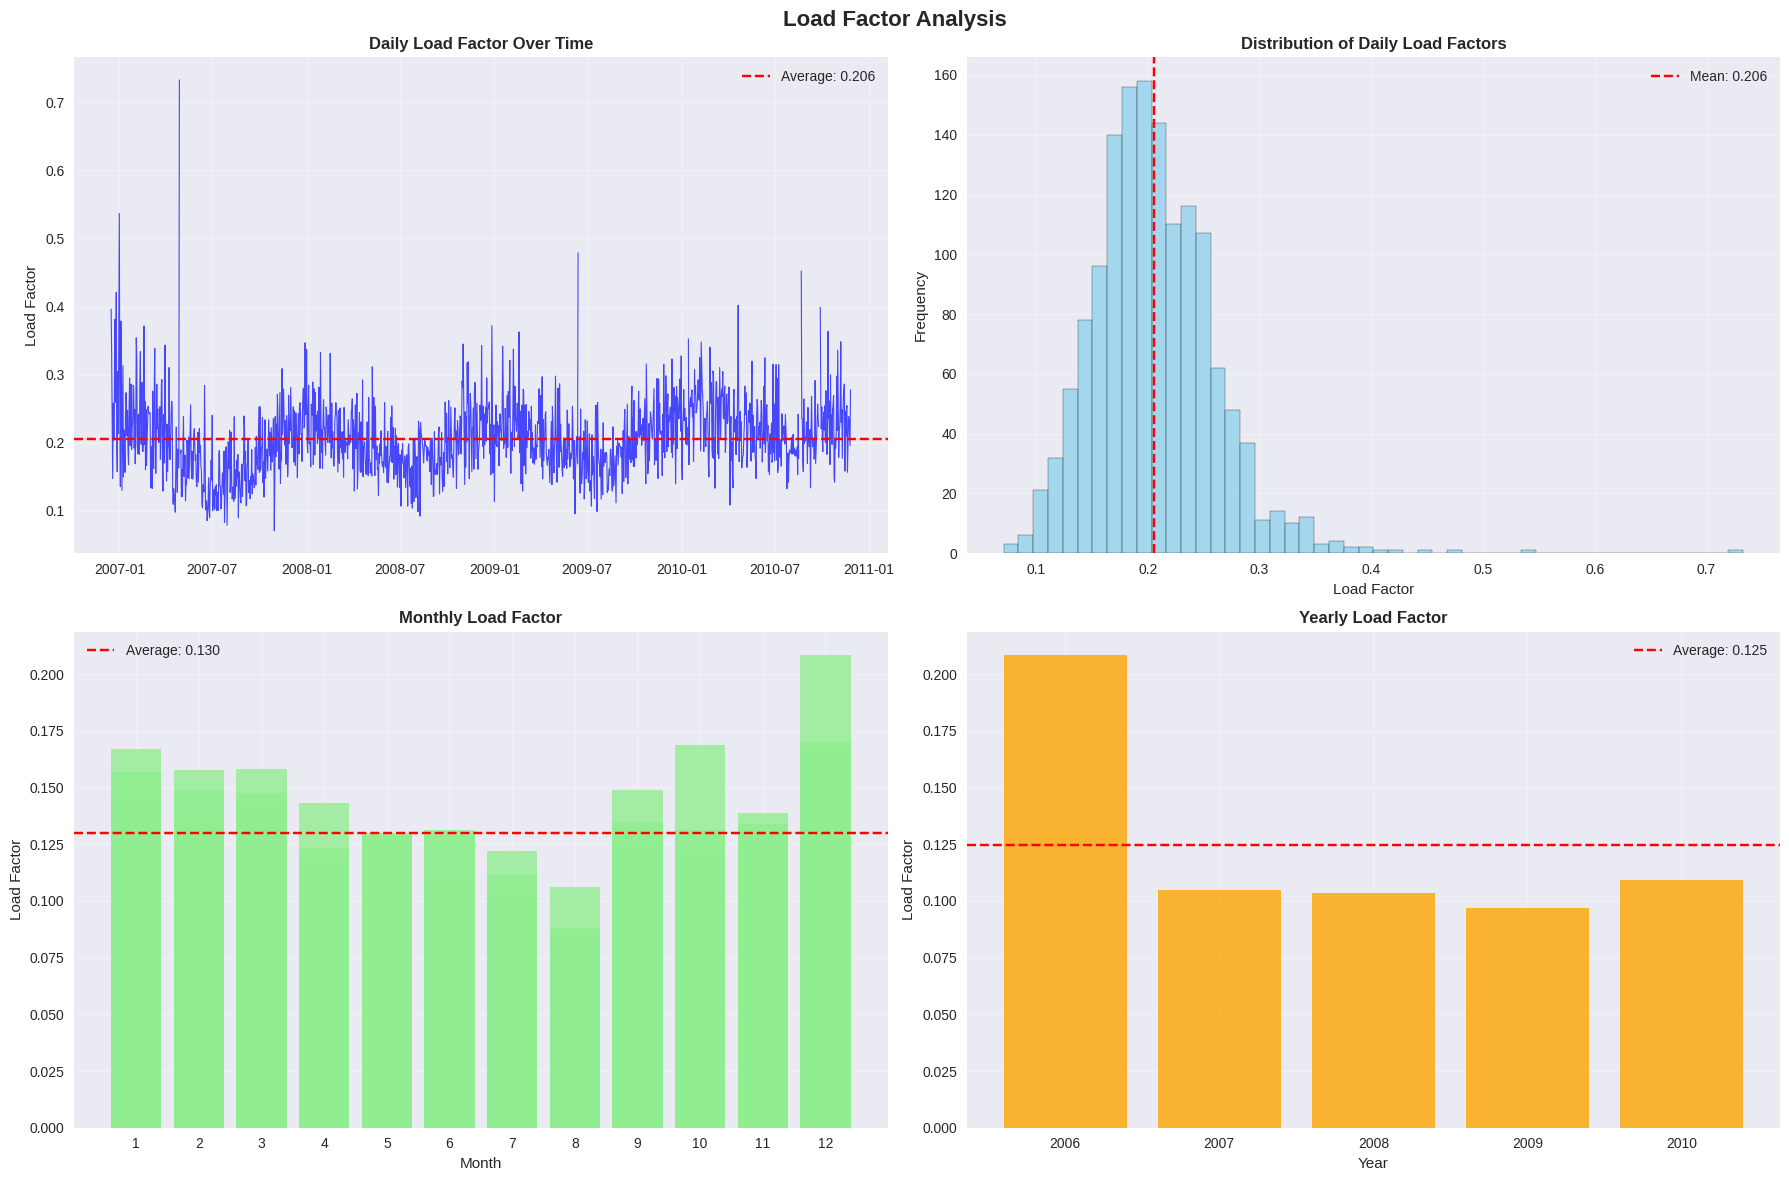


Load Factor Analysis Results:
Overall Load Factor: 0.0981
Daily Load Factor - Mean: 0.2060, Std: 0.0547
Monthly Load Factor - Mean: 0.1301, Std: 0.0277
Yearly Load Factor - Mean: 0.1245, Std: 0.0470


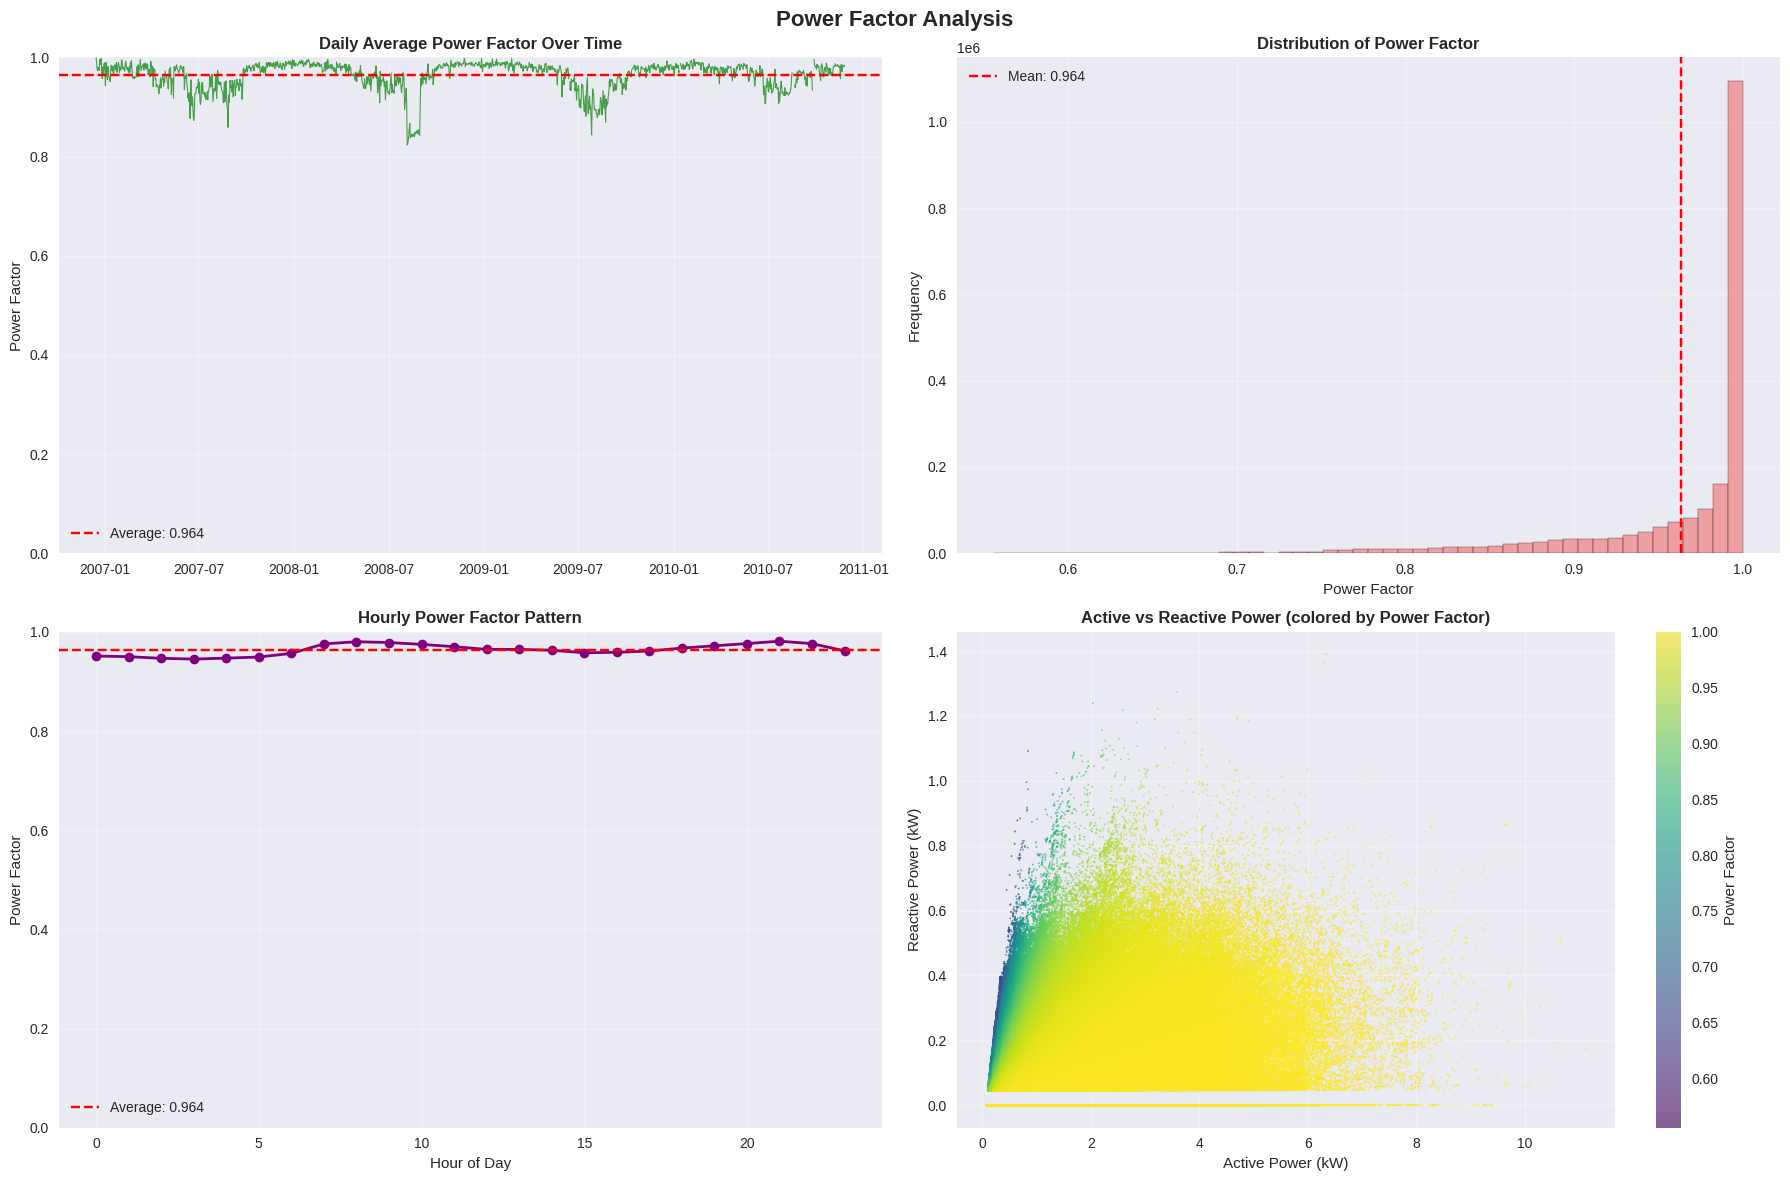


Power Factor Analysis Results:
Overall Power Factor: 0.9637
Power Factor Standard Deviation: 0.0581
Power Factor Range: 0.5559 - 1.0000
Daily Power Factor - Mean: 0.9637, Std: 0.0287
Monthly Power Factor - Mean: 0.9640, Std: 0.0256
Power Factor Quality Assessment: Excellent
Reactive Power Demand: 0.1237 kW (average)


In [3]:
# 8. LOAD FACTOR ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Load Factor Analysis', fontsize=16, fontweight='bold')

# Calculate daily load factors
daily_peak = df['Global_active_power'].resample('D').max()
daily_avg = df['Global_active_power'].resample('D').mean()
daily_load_factor = daily_avg / daily_peak

# Calculate monthly load factors
monthly_peak = df['Global_active_power'].resample('M').max()
monthly_avg = df['Global_active_power'].resample('M').mean()
monthly_load_factor = monthly_avg / monthly_peak

# Calculate yearly load factors
yearly_peak = df['Global_active_power'].resample('Y').max()
yearly_avg = df['Global_active_power'].resample('Y').mean()
yearly_load_factor = yearly_avg / yearly_peak

# Plot 1: Daily load factor over time
axes[0,0].plot(daily_load_factor.index, daily_load_factor.values, alpha=0.7, linewidth=0.8, color='blue')
axes[0,0].axhline(y=daily_load_factor.mean(), color='red', linestyle='--',
                  label=f'Average: {daily_load_factor.mean():.3f}')
axes[0,0].set_title('Daily Load Factor Over Time', fontweight='bold')
axes[0,0].set_ylabel('Load Factor')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Load factor distribution
axes[0,1].hist(daily_load_factor.dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,1].axvline(x=daily_load_factor.mean(), color='red', linestyle='--',
                  label=f'Mean: {daily_load_factor.mean():.3f}')
axes[0,1].set_title('Distribution of Daily Load Factors', fontweight='bold')
axes[0,1].set_xlabel('Load Factor')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Monthly load factor
axes[1,0].bar(monthly_load_factor.index.month, monthly_load_factor.values,
              color='lightgreen', alpha=0.8)
axes[1,0].axhline(y=monthly_load_factor.mean(), color='red', linestyle='--',
                  label=f'Average: {monthly_load_factor.mean():.3f}')
axes[1,0].set_title('Monthly Load Factor', fontweight='bold')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Load Factor')
axes[1,0].set_xticks(range(1, 13))
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Yearly load factor
axes[1,1].bar(yearly_load_factor.index.year, yearly_load_factor.values,
              color='orange', alpha=0.8)
axes[1,1].axhline(y=yearly_load_factor.mean(), color='red', linestyle='--',
                  label=f'Average: {yearly_load_factor.mean():.3f}')
axes[1,1].set_title('Yearly Load Factor', fontweight='bold')
axes[1,1].set_xlabel('Year')
axes[1,1].set_ylabel('Load Factor')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and return overall load factor
overall_peak = df['Global_active_power'].max()
overall_avg = df['Global_active_power'].mean()
overall_load_factor = overall_avg / overall_peak

print(f"\nLoad Factor Analysis Results:")
print(f"Overall Load Factor: {overall_load_factor:.4f}")
print(f"Daily Load Factor - Mean: {daily_load_factor.mean():.4f}, Std: {daily_load_factor.std():.4f}")
print(f"Monthly Load Factor - Mean: {monthly_load_factor.mean():.4f}, Std: {monthly_load_factor.std():.4f}")
print(f"Yearly Load Factor - Mean: {yearly_load_factor.mean():.4f}, Std: {yearly_load_factor.std():.4f}")

# 9. POWER FACTOR ANALYSIS
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Power Factor Analysis', fontsize=16, fontweight='bold')

# Calculate apparent power and power factor
df['Apparent_power'] = np.sqrt(df['Global_active_power']**2 + df['Global_reactive_power']**2)
df['Power_factor'] = df['Global_active_power'] / df['Apparent_power']

# Remove infinite and NaN values for power factor calculations
df_pf_clean = df[np.isfinite(df['Power_factor']) & (df['Power_factor'] > 0) & (df['Power_factor'] <= 1)]

# Calculate daily power factors
daily_pf_avg = df_pf_clean['Power_factor'].resample('D').mean()
daily_active = df['Global_active_power'].resample('D').mean()
daily_reactive = df['Global_reactive_power'].resample('D').mean()

# Calculate monthly power factors
monthly_pf_avg = df_pf_clean['Power_factor'].resample('M').mean()

# Calculate hourly power factors
hourly_pf_avg = df_pf_clean.groupby('Hour')['Power_factor'].mean()

# Plot 1: Power factor over time
axes[0,0].plot(daily_pf_avg.index, daily_pf_avg.values, alpha=0.7, linewidth=0.8, color='green')
axes[0,0].axhline(y=daily_pf_avg.mean(), color='red', linestyle='--',
                  label=f'Average: {daily_pf_avg.mean():.3f}')
axes[0,0].set_title('Daily Average Power Factor Over Time', fontweight='bold')
axes[0,0].set_ylabel('Power Factor')
axes[0,0].set_ylim(0, 1)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Power factor distribution
axes[0,1].hist(df_pf_clean['Power_factor'], bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].axvline(x=df_pf_clean['Power_factor'].mean(), color='red', linestyle='--',
                  label=f'Mean: {df_pf_clean["Power_factor"].mean():.3f}')
axes[0,1].set_title('Distribution of Power Factor', fontweight='bold')
axes[0,1].set_xlabel('Power Factor')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Hourly power factor pattern
axes[1,0].plot(hourly_pf_avg.index, hourly_pf_avg.values, marker='o', linewidth=2, color='purple')
axes[1,0].axhline(y=hourly_pf_avg.mean(), color='red', linestyle='--',
                  label=f'Average: {hourly_pf_avg.mean():.3f}')
axes[1,0].set_title('Hourly Power Factor Pattern', fontweight='bold')
axes[1,0].set_xlabel('Hour of Day')
axes[1,0].set_ylabel('Power Factor')
axes[1,0].set_ylim(0, 1)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Active vs Reactive Power with Power Factor contours
scatter = axes[1,1].scatter(df_pf_clean['Global_active_power'], df_pf_clean['Global_reactive_power'],
                           c=df_pf_clean['Power_factor'], cmap='viridis', alpha=0.6, s=1)
axes[1,1].set_title('Active vs Reactive Power (colored by Power Factor)', fontweight='bold')
axes[1,1].set_xlabel('Active Power (kW)')
axes[1,1].set_ylabel('Reactive Power (kW)')
plt.colorbar(scatter, ax=axes[1,1], label='Power Factor')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate and return power factor metrics
overall_power_factor = df_pf_clean['Power_factor'].mean()
power_factor_std = df_pf_clean['Power_factor'].std()
power_factor_min = df_pf_clean['Power_factor'].min()
power_factor_max = df_pf_clean['Power_factor'].max()

print(f"\nPower Factor Analysis Results:")
print(f"Overall Power Factor: {overall_power_factor:.4f}")
print(f"Power Factor Standard Deviation: {power_factor_std:.4f}")
print(f"Power Factor Range: {power_factor_min:.4f} - {power_factor_max:.4f}")
print(f"Daily Power Factor - Mean: {daily_pf_avg.mean():.4f}, Std: {daily_pf_avg.std():.4f}")
print(f"Monthly Power Factor - Mean: {monthly_pf_avg.mean():.4f}, Std: {monthly_pf_avg.std():.4f}")

# Power factor quality assessment
if overall_power_factor >= 0.95:
    pf_quality = "Excellent"
elif overall_power_factor >= 0.90:
    pf_quality = "Good"
elif overall_power_factor >= 0.85:
    pf_quality = "Fair"
else:
    pf_quality = "Poor"

print(f"Power Factor Quality Assessment: {pf_quality}")
print(f"Reactive Power Demand: {df['Global_reactive_power'].mean():.4f} kW (average)")